In this self study you will explore Pyro a bit further, bu as opposed to the last self study session where focus was on modeling we will here take a slightly closer lool at (variational) inference. in Pyro 

Before starting on today's self studies, you should finish the self studies from last tme if you have not already done so. Also, if needed, consider revisiting the Pyro documentation listed under reading material for the last two lectures:
* http://pyro.ai/examples/intro_long.html
* http://pyro.ai/examples/bayesian_regression.html
* http://pyro.ai/examples/svi_part_i.html

Afterwards, continue with the notebook below, where we consider (Bayesian) linear regression using Pyro based on the same setup as in the lecture. 

In [1]:
import pyro
import torch
import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
import numpy as np

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

c:\Users\chris\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generate data
This data generation is similar to what was done during the lecture; we have one predictor variable 'x' and one response variable 'y', but here collected in a  dictionary.

In [108]:
def generate_data(N=10, true_w0= 1., true_w1=.5):
    gamma = 4.  # The *precision* in the observation noise
    st_dev = 0.1 / np.sqrt(gamma)  # And corresponding standard deviation
    np.random.seed(123)
    x = 5 * np.random.rand(N)  # The x-points are sampled uniformly on [0, 5]
    y = np.random.normal(loc=true_w0 + true_w1 * x, scale=st_dev)  # And the response is sampled from the Normal
    return {"x": torch.tensor(x, dtype=torch.float), "y": torch.tensor(y, dtype=torch.float)}

Helper function for visualizing the data as well as the true and learned functions

In [109]:
def data_plotter(data, true_w0=None, true_w1=None,
                 approx_w0=None, approx_w1=None):
    """
    Use to plot data. If y is not none it contains responses, and (x,y) will be scatter-plotted
    If neither true_w0 nor true_w1 is None, we will plot the line true_w0 + x * true_w1 in red.
    If neither approx_w0 nor approx_w1 is None, we plot the line approx_w0 + x * approx_w1 in green.
    """
    if data is not None:
        plt.plot(data["x"].numpy(), data["y"].numpy(), "bo")

    # Plot true line if given
    if true_w0 is not None and true_w1 is not None:
        plt.plot(data["x"].numpy(), true_w0 + true_w1 * data["x"].numpy(), "r-")

    # Plot approximation if given
    if approx_w0 is not None and approx_w1 is not None:
        plt.plot(data["x"].numpy(), approx_w0+ approx_w1* data["x"].numpy(), "g-", alpha=.2)


Generate a data set with 50 data points

In [110]:
true_w0= 1.
true_w1=.5
data = generate_data(N=100, true_w0=true_w0, true_w1=true_w1)

Plot the data together with the regression line around which the data has been generated.

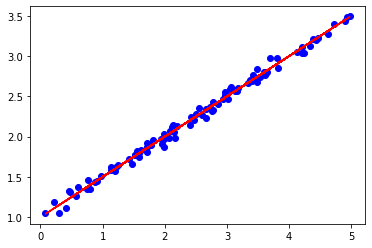

In [111]:
data_plotter(data, true_w0=true_w0, true_w1=true_w1)

## Specification of the Pyro model and guide

Here we specify a (Bayesian) linear regression model in Pyro. The 'data' argument is a dictionary covering the data of the predictor and response variable

In [112]:
def lin_reg_model(data):

    w0 = pyro.sample("w0", dist.Normal(0.0, 1.0))
    w1 = pyro.sample("w1", dist.Normal(0.0, 1000.0))

    with pyro.plate("data_plate"):
        pyro.sample("y", dist.Normal(data["x"] * w1 + w0, 1.0), obs=data["y"])

Here we specify the variational distribution, which is called a guide in Pyro. We make the mean field assumption and assume that the variational distribution factorizes wrt. to 'w0' and 'w1'.

In [113]:
def lin_reg_guide(data):
    w0_mean = pyro.param("w0_mean", torch.tensor(1.0))
    w0_scale = pyro.param("w0_scale", torch.tensor(1.0), constraint=constraints.positive)
    pyro.sample("w0", dist.Normal(w0_mean, w0_scale))
    
    w1_mean = pyro.param("w1_mean", torch.tensor(0.0))
    w1_scale = pyro.param("w1_scale", torch.tensor(1.0), constraint=constraints.positive)
    pyro.sample("w1", dist.Normal(w1_mean, w1_scale))

### Learning

In this function the actual learning is taking place. Notice that the structure is similar to what we saw in the example notebooks during the lecture.

In [117]:
def learn(N=10, data=None):
    if data is None:
        data = generate_data(N=N)

    pyro.clear_param_store()

    elbo = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(model=lin_reg_model,
                         guide=lin_reg_guide,
                         optim=SGD({"lr": 0.0001}),
                         loss=elbo)

    num_steps = 5000
    for step in range(num_steps):
        loss = svi.step(data)

        if step % 100 == 0:
            w0_mean = pyro.param("w0_mean").detach().item()
            w0_scale = pyro.param("w0_scale").detach().item()
            w1_mean = pyro.param("w1_mean").detach().item()
            w1_scale = pyro.param("w1_scale").detach().item()
            print(f"Loss (iter: {step}): {loss}")
            print(f"w0: {w0_mean} +/- {w0_scale}\t \t w1: {w1_mean} +/- {w1_scale}")

In [118]:
learn(data=data)

Loss (iter: 0): 536.1274846792221
w0: 0.9722892045974731 +/- 0.9843472242355347	 	 w1: -0.08223489671945572 +/- 0.8934556841850281
Loss (iter: 100): 121.00818210840225
w0: 1.114156723022461 +/- 0.600652277469635	 	 w1: 0.5046518445014954 +/- 0.2339170277118683
Loss (iter: 200): 117.21474361419678
w0: 1.0714117288589478 +/- 0.4524116516113281	 	 w1: 0.46649059653282166 +/- 0.17621557414531708
Loss (iter: 300): 115.32416754961014
w0: 1.0548319816589355 +/- 0.3931651711463928	 	 w1: 0.4818738102912903 +/- 0.14347338676452637
Loss (iter: 400): 104.53887039422989
w0: 1.0512292385101318 +/- 0.3652747571468353	 	 w1: 0.47968021035194397 +/- 0.12568451464176178
Loss (iter: 500): 114.42244452238083
w0: 1.030500054359436 +/- 0.32562610507011414	 	 w1: 0.46134376525878906 +/- 0.11311579495668411
Loss (iter: 600): 106.62713700532913
w0: 1.0428451299667358 +/- 0.2967079281806946	 	 w1: 0.5372744798660278 +/- 0.10352716594934464
Loss (iter: 700): 107.17946290969849
w0: 1.0225197076797485 +/- 0.27515

### Analyze the results

Here we sample weights from the posterior distributions over 'w0' and 'w1'. The distribution of the generated weights (and the corresponding models) illustrates how confident we are in the model, an insight you cannot get when only having point estimates of the model parameters as found with, e.g., maximum likelihood learning. 

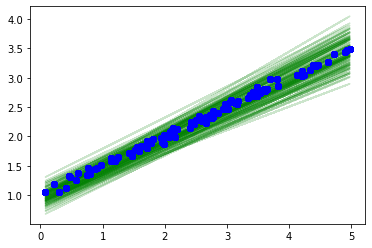

In [122]:
for _ in range(100):
    w0_mean = pyro.param("w0_mean").detach().item()
    w0_scale = pyro.param("w0_scale").detach().item()
    w1_mean = pyro.param("w1_mean").detach().item()
    w1_scale = pyro.param("w1_scale").detach().item()
    w0_sample = pyro.sample("w0_sample", dist.Normal(w0_mean, w0_scale)).numpy()
    w1_sample = pyro.sample("w1_sample", dist.Normal(w1_mean, w1_scale)).numpy()
    data_plotter(data, approx_w0=w0_sample, approx_w1=w1_sample)
data_plotter(data)
plt.show()

## Exercises:
* Generate data sets of varying sizes and characteristics (by changing the parameters in the 'generate_data' function) and investigate and compare the resulting models.
* Analyze how learning is affected by changing the learning rate and the initial values of the parameters specified in the guide function.
* Experiment with different types of prior knowledge in the model specification (e.g. change the mean and scale of the distributions over the weights). For instance, we may (mostly likely erroneously considering the data) have a prior expectation that 'w0' is around 5.0, and we can encode the strength of this belief through the scale of the corresponding distribution. 